# **Segment seismic images with U-Net**

The objective of this notebook is to present a simple example to segment seismic images with U-Net. We use the dataset from TGS-Kaggle Salt Identification Challenge as it offers a preprocessed but well curated dataset consisting of seismic images that represent the practical world scenario.

Downloading data:
- Create a user account on https://www.kaggle.com.
- Install Kaggle API by executing the following command in Windows command prompt or OS terminal:
<br/> `pip install kaggle`
- Follow the instructions at https://www.kaggle.com/docs/api to generate and copy the kaggle.json file to set-up your machine for using Kaggle API.
- Navigate to the directory in Windows command prompt or OS terminal, where this Jupyter notebook is located.
- Execute following command to download the zip file containing data used in this notebook.
<br/> `kaggle competitions download -c tgs-salt-identification-challenge`
- Unzip the downloaded tgs-salt-identification-challenge.zip file. Inside the unzipped folder `tgs-salt-identification-challenge`, locate competition_data.zip file. Unzip competition_data.zip. 
- Create a directory named `kaggle_data` in the same directory, where this Jupyter notebook is located. 
- Copy the extracted `competition_data` folder such that the `train` and `test` folders containing the seismic images are located at `./kaggle_data/competition_data/train/` and `./kaggle_data/competition_data/test/` paths respectively.

Note:
- Training the U-Net model in this example is computationally demanding. If the computer that you are using doesn't have a NVIDIA GPU and TensorFlow GPU version installed, it may take quite some time for training the U-Net model.
- You may not have tqdm package in the Anaconda installation. Install it using the following command:
<br/> `conda install -c conda-forge tqdm`

In [1]:
!pip install kaggle

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm 
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow 

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

To make the experiments reproducible, we are setting random seeds in both TensorFlow as well as numpy.

In [3]:
tensorflow.random.set_seed(42)
np.random.seed(42)

Set the path to the training and test data.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving competition_data.zip to competition_data.zip


In [5]:
!unzip competition_data

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/competition_data/train/masks/._7e68df3981.png  
  inflating: competition_data/train/masks/851a37ac37.png  
  inflating: __MACOSX/competition_data/train/masks/._851a37ac37.png  
  inflating: competition_data/train/masks/6010b9b84d.png  
  inflating: __MACOSX/competition_data/train/masks/._6010b9b84d.png  
  inflating: competition_data/train/masks/f64190c47e.png  
  inflating: __MACOSX/competition_data/train/masks/._f64190c47e.png  
  inflating: competition_data/train/masks/ec3130dd0b.png  
  inflating: __MACOSX/competition_data/train/masks/._ec3130dd0b.png  
  inflating: competition_data/train/masks/894b9ae774.png  
  inflating: __MACOSX/competition_data/train/masks/._894b9ae774.png  
  inflating: competition_data/train/masks/6a57dfd211.png  
  inflating: __MACOSX/competition_data/train/masks/._6a57dfd211.png  
  inflating: competition_data/train/masks/9b656c339a.png  
  inflating: __MACOSX/competition_data/train/m

In [22]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

path_train = 'competition_data/train/'
path_test = 'competition_data/test/'

In [7]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        x_img = img_to_array(load_img(path + '/images/' + id_, grayscale=True))
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=False))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 4000/4000 [00:36<00:00, 110.72it/s]


In [8]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [10]:
def UNet(input_image, n_filters=16, dropout=0.5, batchnorm=True):
    # Encoder
    c1 = conv2d_block(input_image, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Decoder
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [11]:
input_img = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 1), name='img')
model = UNet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

In [13]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model/model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train, batch_size=16, epochs=10, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

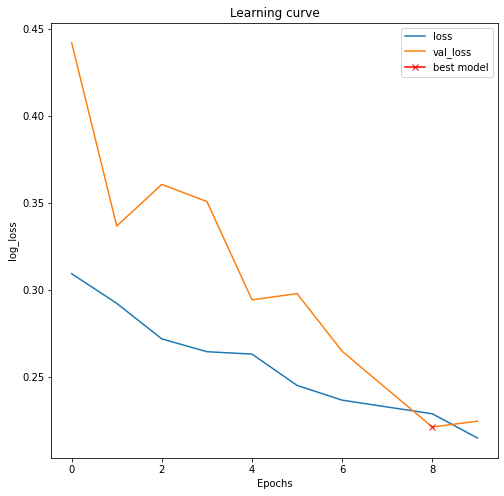

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [15]:
# Load best model
model.load_weights('model/model-tgs-salt.h5')

In [16]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

19/19 [==============================] - 3s 104ms/step - loss: 0.2213 - accuracy: 0.7450


[0.22133232653141022, 0.7449789643287659]

In [17]:
# Predict on train, val and test
train_probabilities = model.predict(X_train, verbose=1)
validation_probabilities = model.predict(X_valid, verbose=1)

# Threshold predictions
train_predictions = (train_probabilities > 0.5).astype(np.uint8)
validation_predictions = (validation_probabilities > 0.5).astype(np.uint8)

19/19 [==============================] - 1s 62ms/step


In [18]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('Seismic image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Given label')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Probabilities')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Predicted label');

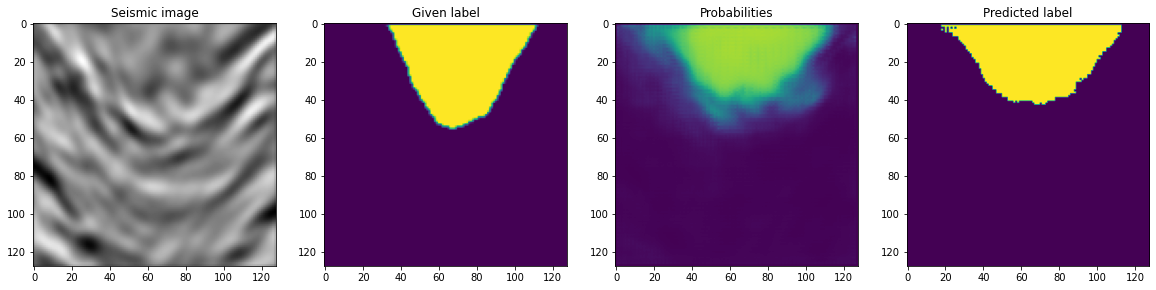

In [19]:
# Plot a few samples of validation data
plot_sample(X_valid, y_valid, validation_probabilities, validation_predictions, ix=19)

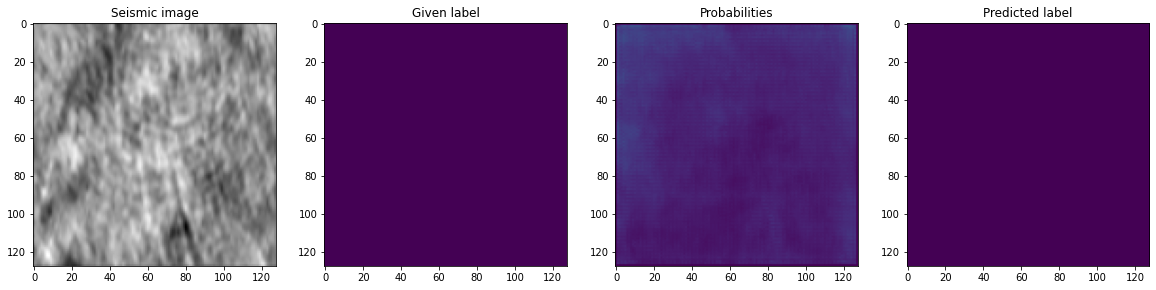

In [20]:
# Plot a few samples of validation data
plot_sample(X_valid, y_valid, validation_probabilities, validation_predictions, ix=31)

In [23]:
X_test = get_data(path_test, train=False)

  0%|          | 0/18000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 18000/18000 [01:06<00:00, 269.18it/s]


In [24]:
# Predict on train, val and test
test_probabilities = model.predict(X_test, verbose=1)

# Threshold predictions
test_predictions = (test_probabilities > 0.5).astype(np.uint8)

563/563 [==============================] - 36s 64ms/step


In [25]:
def plot_test_sample(X, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('Seismic image')

    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[1].set_title('Probabilities')
    
    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted label');

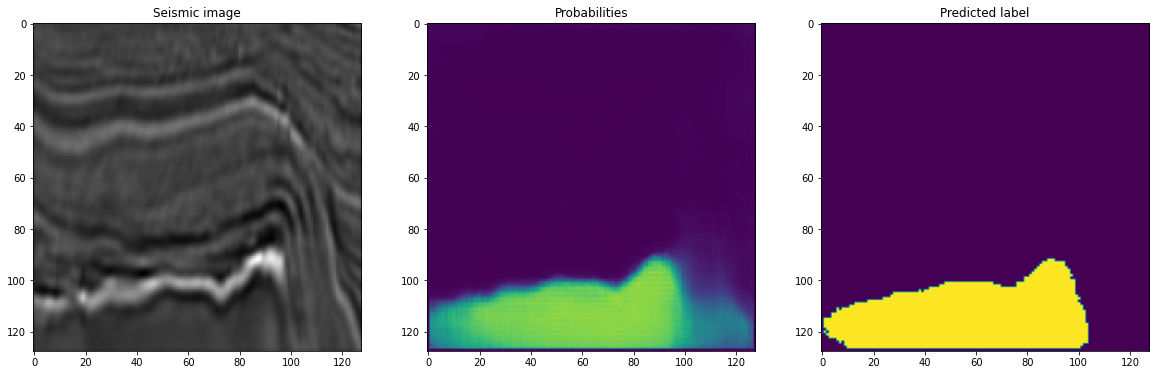

In [26]:
plot_test_sample(X_test, test_probabilities, test_predictions, ix=1734)